In [92]:
# 모델 분석에 필요한 라이브러리 import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import platform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# 모듈로 구현한 데이터 분석용 클래스 import 
from modules.DataAnalysis import DataCheck
from modules.DataAnalysis import DataPreprocessing
from modules.DataAnalysis import DataVisualize
import modules.DataModify as DataModify

In [93]:
# 데이터 로드 & 전처리
input_file_path = './data/Tree_data.csv'
df = pd.read_csv(input_file_path)

# 객체 인스턴스 생성
dc = DataCheck(df)
dp = DataPreprocessing(df)
dv = DataVisualize(df)

# 필요 없는 컬럼 제거
drop_cols = ['No','Plot','Adult','Subplot','Core','Census','Time']
dp.set_drop_cols(drop_cols)

# 인코딩
encode = dp.run(encoding='label', return_anomaly=False)

# Alive 여부 분리
alive_data = encode[encode['Alive'] != 1]
censored_data = encode[encode['Alive'] == 1]

# train/test 분리
train_set, test_set = DataModify.train_test_split_ignore_censored(alive_data, censored_data)

X_train, y_train = train_set   # X_train: 특성, y_train: Alive 라벨
X_test,  y_test  = test_set

print(train_set[1].value_counts())


Alive
0    1802
1     564
Name: count, dtype: int64


In [95]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedKFold

# X_train, y_train = train_set
# X_test, y_test = test_set

# # y_train 처리
# if isinstance(y_train, pd.DataFrame):
#     y_train = y_train.iloc[:, 0]  
# y_train = y_train.values.ravel()
# y_train = y_train.astype(int)

# # y_test 처리
# if isinstance(y_test, pd.DataFrame):
#     y_test = y_test.iloc[:, 0] 
# y_test = y_test.values.ravel()
# y_test = y_test.astype(int)

# # 모델 학습
# lr_clf = LogisticRegression()

# kfold = StratifiedKFold(n_splits=5, shuffle=True)

# # 평가
# lr_clf.fit(X_train, y_train)

# y_pred_train = lr_clf.predict(X_train)
# y_pred_test = lr_clf.predict(X_test)

# # 정확도
# print(accuracy_score(y_train, y_pred_train))
# print(accuracy_score(y_test, y_pred_test))

# # 혼동 행렬
# print(confusion_matrix(y_test, y_pred_test)) 
# print(classification_report(y_test, y_pred_test)) 

In [96]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ===== 데이터 준비 =====
X_train, y_train = train_set
X_test,  y_test  = test_set

def to_1d_int(y):
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
    return y.values.ravel().astype(int)

y_train = to_1d_int(y_train)
y_test  = to_1d_int(y_test)

# ===== 파이프라인 (스케일링 + 로지스틱) =====
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

# ===== 하이퍼파라미터 탐색 공간 =====
param_grid = {
    "clf__C": np.logspace(-3, 2, 6),          # 규제 강도 (0.001 ~ 100)
    "clf__penalty": ["l2"],                   # 기본 L2 (필요시 'l1', 'elasticnet'도 가능, solver='saga' 필요)
    "clf__solver": ["lbfgs", "liblinear"],    # solver 선택
    "clf__class_weight": [None, "balanced"],  # 클래스 불균형 처리 여부
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ===== GridSearchCV =====
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",   # 필요시 'roc_auc', 'f1' 등으로 교체
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("Params:", gs.best_params_)
print("CV:", gs.best_score_)

# ===== 최적 모델로 테스트셋 평가 =====
best_model = gs.best_estimator_
y_pred_test = best_model.predict(X_test)

print("정밀도:", accuracy_score(y_test, y_pred_test))
print("\n혼동 행렬:\n", confusion_matrix(y_test, y_pred_test))
print("\n혼동 행렬:\n", classification_report(y_test, y_pred_test))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Params: {'clf__C': np.float64(0.01), 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
CV: 0.7628995281041204
정밀도: 0.8028846153846154

혼동 행렬:
 [[301  21]
 [ 61  33]]

혼동 행렬:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       322
           1       0.61      0.35      0.45        94

    accuracy                           0.80       416
   macro avg       0.72      0.64      0.66       416
weighted avg       0.78      0.80      0.78       416



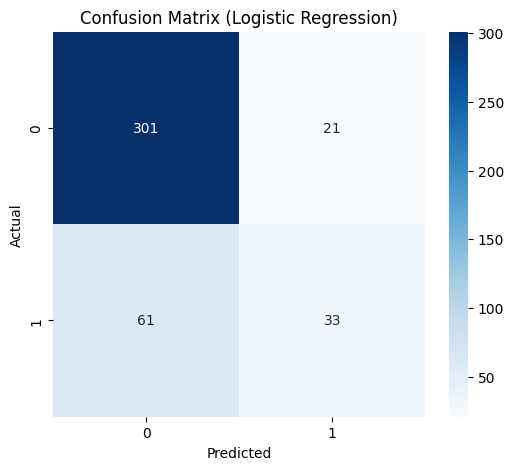

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


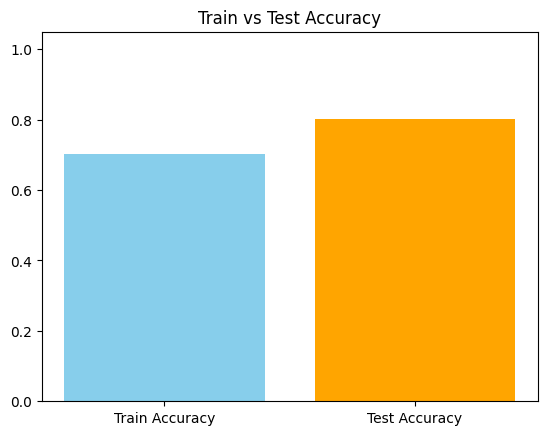

In [98]:
scores = [accuracy_score(y_train, y_pred_train),
          accuracy_score(y_test, y_pred_test)]

plt.bar(['Train Accuracy', 'Test Accuracy'], scores, color=['skyblue','orange'])
plt.ylim(0,1.05)
plt.title("Train vs Test Accuracy")
plt.show()

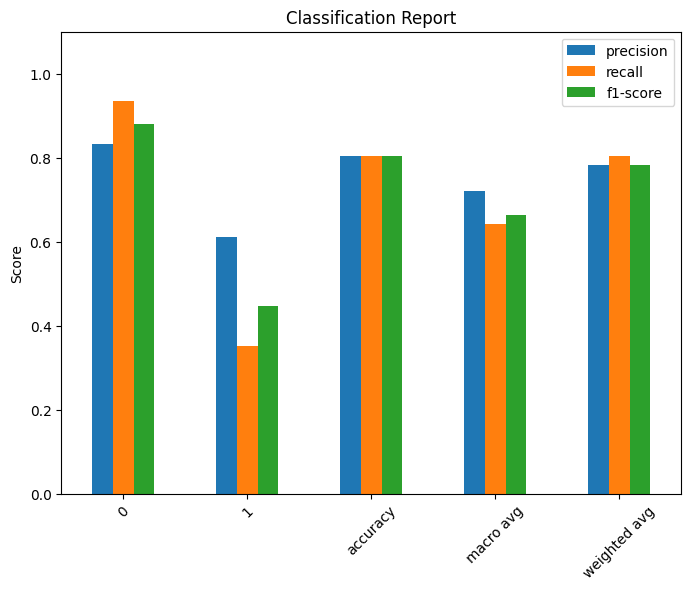

In [99]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred_test, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# F1-score만 시각화 예시
df_report[['precision','recall','f1-score']].plot(kind='bar', figsize=(8,6))
plt.title("Classification Report")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0,1.1)
plt.show()
